In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves')

In [2]:
from help_funcs import * 
# from eofs.xarray import Eof
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import importlib
import xarray as xr
# importlib.reload(xr)
import seaborn as sns
import pandas as pd
import cmocean.cm as cm
import netCDF4 as nc
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt

In [3]:
sns.set_context("poster")

In [5]:
def rm_each_month_mean(ds):
    xy_mean = ds["thetao"].mean(dim=['latitude', 'longitude'], skipna=True)
    z_mean = xy_mean.mean(dim = "depth")
    return xy_mean - z_mean
def remove_seasonal(ds):
    climatology = ds.groupby("time.month").mean("time")
    anomalies = ds.groupby("time.month") - climatology
    return anomalies.drop("month")
def remove_daily_clim(ds):
    climatology = ds.groupby("time.dayofyear").mean("time")
    anomalies = ds.groupby("time.dayofyear") - climatology
    return anomalies.drop("dayofyear")

In [6]:
%time
from pathlib import Path
from natsort import natsorted
GLORYS_dir = r"/vortexfs1/home/anthony.meza/GLORYS_data" 
results = [str(result) for result in list(Path(GLORYS_dir).rglob("*.[nN][cC]"))] #get all files
results = natsorted(results) #sort all files 

years = natsorted(list(set([result[41:45] for result in results])))
months = natsorted(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

CPU times: user 1 µs, sys: 2 µs, total: 3 µs
Wall time: 5.96 µs


In [7]:
#trying to recreate line 90 in California
# y = mx + b 
x0 = -117; y0 = 33
m = ((33 - 31) / (x0 - -125))
b = y0- x0*m 
line = lambda x : m*x + b
xs_C = np.linspace(-125, x0)
ys_C = line(xs_C)

In [8]:
def read_ds(fname): #very little memory footprint, 1 day = 500kib
    with xr.open_dataset(fname) as ds:
        ds_new = ds[["thetao", "so"]]
        ds_new = ds_new.sel(longitude = slice(-128, -115), latitude = slice(25, 35))
        return ds_new

In [9]:
# # with xr.open_dataset(results[0]) as ds:
#     print(ds.latitude.min(), ds.latitude.max())
#     print(ds.longitude.min(), ds.longitude.max())

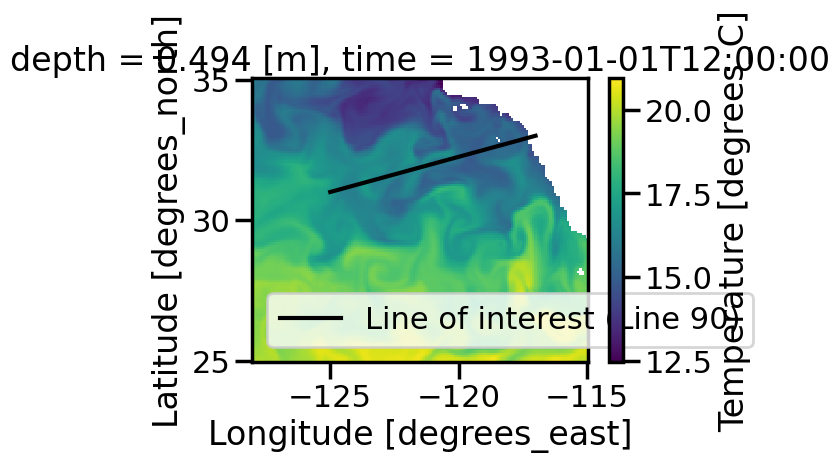

In [12]:
# %%time Must uses axes when plotting with xarray, else there will be a memory leak 
fig, axes = plt.subplots()
with read_ds(results[0]) as ds:
    LONS, LATS = np.meshgrid(ds.longitude, ds.latitude)
    axes.plot(xs_C, ys_C, color = "black", label = "Line of interest (Line 90)"); 
    ds.thetao.isel(time = 0, depth = 0).plot(ax = axes)
    axes.legend()
    fig.tight_layout()

In [11]:
with read_ds(results[0]) as ds:
    i_ind, j_ind = get_latlon_idx(ds, xs_C, ys_C)


In [83]:
#sample along the line 
prev_ind = (np.nan, np.nan)
lons_list = []
lats_list = []
i_ind = []
j_ind = []
tot_dist = []
for (x, y) in zip(xs_C, ys_C): 
    new_ind = where_haversine_min(x, y, LONS, LATS)
    is_unique = new_ind !=prev_ind
    if is_unique:
        i_ind.append(new_ind[0])
        j_ind.append(new_ind[1])
        lons_list.append(LONS[new_ind[0], new_ind[1]])
        lats_list.append(LATS[new_ind[0], new_ind[1]])
        tot_dist.append(haversine_np(lons_list[-1], lats_list[-1], xs_C[-1], ys_C[-1]))
        
    prev_ind = new_ind
#now we have a set of sample pts along a line 

In [84]:
lat_inds = xr.DataArray(i_ind, dims="points")
lon_inds = xr.DataArray(j_ind, dims="points")
def read_ds_line90(fname): #very little memory footprint, 1 day = 500kib
    with xr.open_dataset(fname) as ds:
        ds_new = ds[["thetao", "so"]]
        ds_new = ds_new.sel(longitude = slice(-128, -115), latitude = slice(25, 35))
        ds_new = ds_new.isel(longitude = lon_inds, latitude = lat_inds)
        ds_new = ds_new.mean(dim=['points'], skipna=True) 
        return ds_new

## Getting GLORYS Temperatures for all time on line 90

In [85]:
%%time 
from multiprocessing import Pool
import os 
import multiprocessing
n_cores = 31
from os.path import exists
file_not_exist = not(exists("GLORYS_processed/GLORYS_TandS_SoCal_fulldepth.nc"))

CPU times: user 199 µs, sys: 368 µs, total: 567 µs
Wall time: 25.6 ms


In [86]:
if file_not_exist:
    print("File does not exist, will download data.")
    print("Requires at least 55 GB of RAM and 40 minutes of time")
    CAL_dataset = []
    for year in years:
        print(year)
        files = np.empty(0, dtype = str)
        for month in months:
            file_path = GLORYS_dir + "/" + year + "/" + month
            file_list = natsorted([str(result) for result in list(Path(GLORYS_dir + "/" + year + "/" + month + "/").rglob("*.[nN][cC]"))])
            files = np.concatenate([files, file_list])
        files = natsorted([str(f) for f in files])
        if __name__ == '__main__':
            with Pool(n_cores) as p:
                datasets = p.map(read_ds_line90, files)
        datasets = [d for d in datasets]
        CAL_dataset = CAL_dataset + datasets #about 50 gigs of data!! 


    ds = xr.concat(CAL_dataset, dim = "time", data_vars = "minimal", coords = "minimal")
    ds = ds.sortby("time")
    ds.to_netcdf("GLORYS_processed/GLORYS_TandS_SoCal_fulldepth.nc")
else:
    print("File found, loading file")
    ds = xr.open_dataset("GLORYS_processed/GLORYS_TandS_SoCal_fulldepth.nc")

File found, loading file


In [87]:
theta_TS = ds.thetao;
salinity_TS = ds.so;

### Get NINO 3.4 Index

In [88]:
df = pd.read_csv("nino34.long.csv", index_col=0)
dates_df = df.astype("datetime64[D]")
for year in range(0, len(df.index)):
    for month in range(1, len(df.columns)+1):
        dates_df.iloc[year, month - 1] = np.datetime64(pd.Timestamp(df.index[year], month, 15), "D")
NINO34_ds = xr.DataArray(
            data=df.values.flatten(),
            dims=["time"],
            coords=dict(time=dates_df.values.flatten()))
NINO34 = NINO34_ds.sel(time = slice("1993", None))

### Get monthly anomalies from each dset 

In [89]:
theta_anom = remove_seasonal(theta_TS) #pot. temp anomaly
salinity_anom = remove_seasonal(salinity_TS) #salinity anomaly

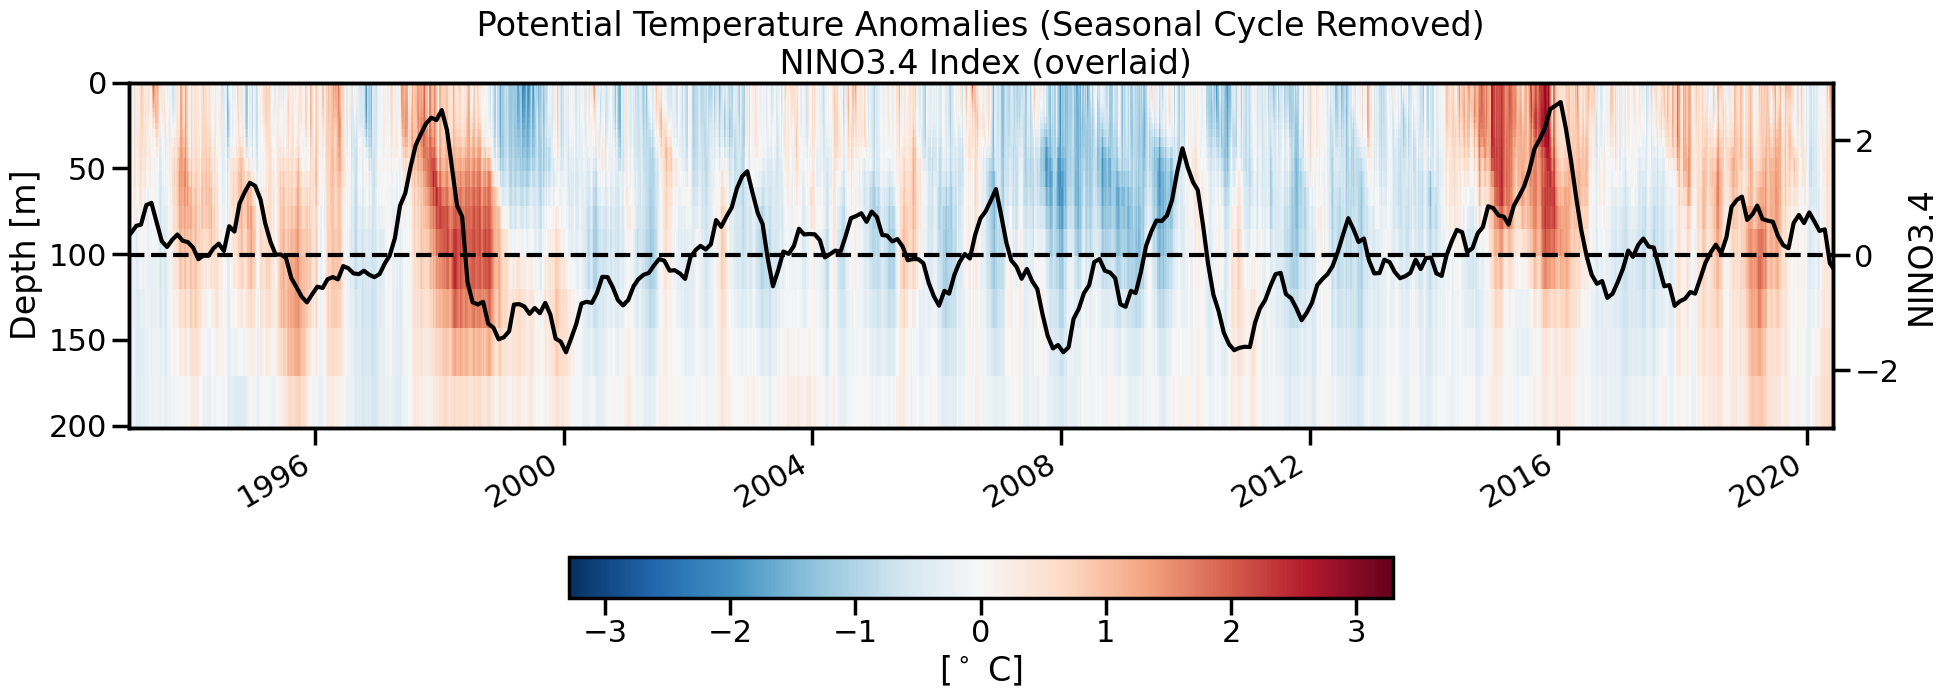

In [90]:
import cmocean.cm as cm 
theta_anom_crop = theta_anom.sel(dict(time = slice(None, "2022"), depth = slice(0, 200))).transpose() #crop
fig, axes = plt.subplots(figsize = (20, 7.5))
theta_anom_crop.plot.pcolormesh(ax=axes, 
                cbar_kwargs={'label' : r"[$^\circ$ C]", 
                             'orientation':"horizontal", 
                             "fraction":0.08, 
                             "pad":0.25})
axes.set_xlabel("")
axes.invert_yaxis()
ax2=axes.twinx()
ax2.hlines(0, axes.get_xlim()[0], axes.get_xlim()[1], linestyle = "--", color = "k")
remove_seasonal(NINO34).plot(ax = ax2, color = "k")
ax2.set_ylabel("NINO3.4",color="black")
ax2.set_ylim(-3, 3)
axes.set_title(" Potential Temperature Anomalies (Seasonal Cycle Removed) \n NINO3.4 Index (overlaid)")
fig.tight_layout();

fig.savefig("TempAnom.png",  dpi = 400)

### Zoom in on 1996 El Nino 

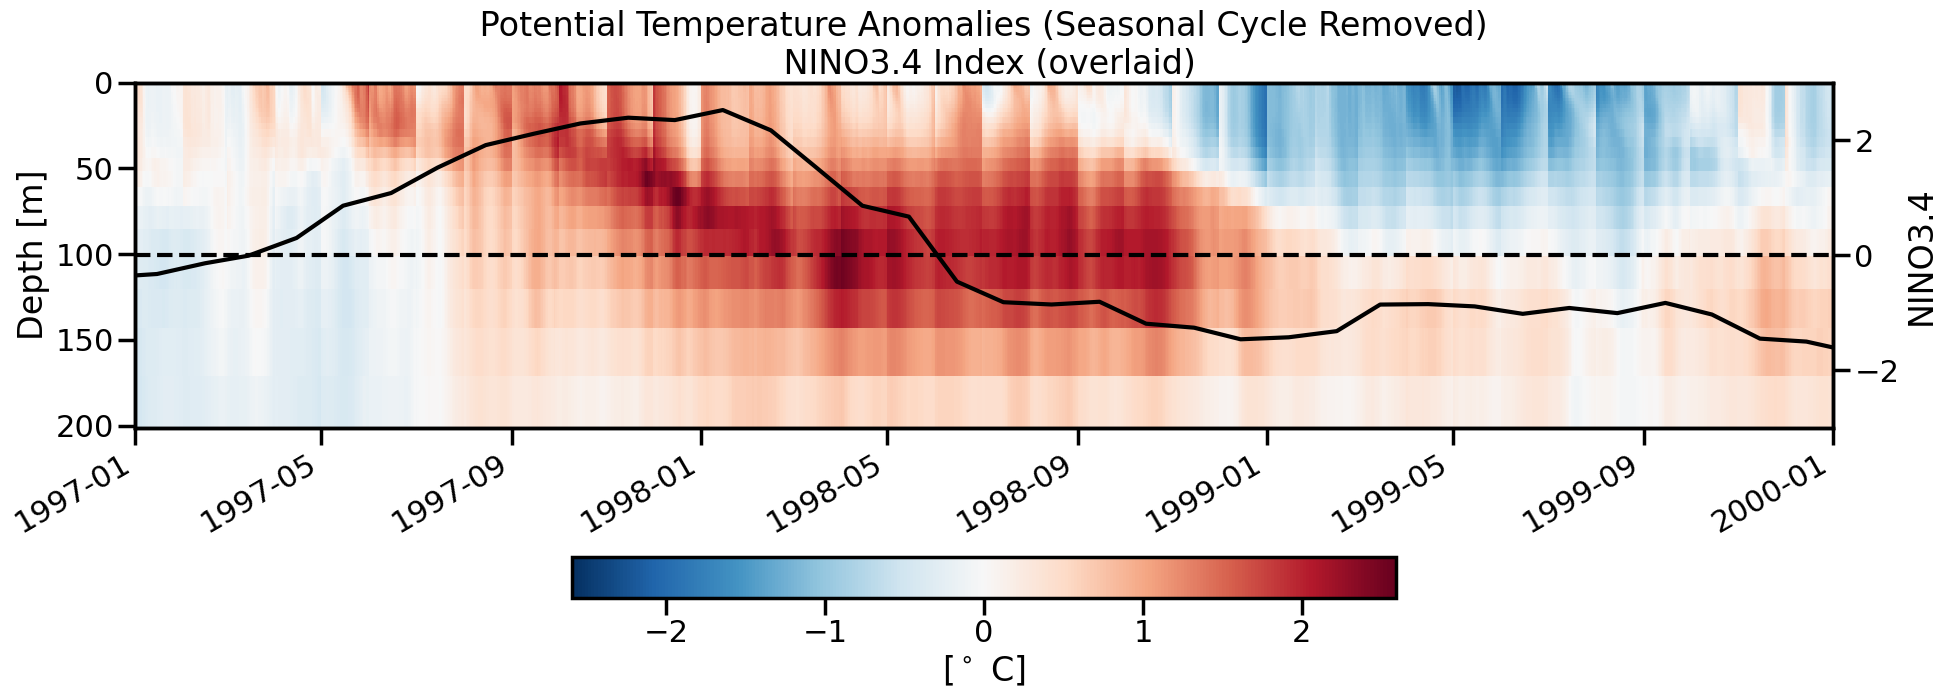

In [91]:
time_slice= slice("1997", "1999")
theta_anom_crop = theta_anom.sel(dict(time = time_slice, depth = slice(0, 200))).transpose() #crop
fig, axes = plt.subplots(figsize = (20, 7.5))
theta_anom_crop.plot(ax=axes, 
                cbar_kwargs={'label' : r"[$^\circ$ C]", 
                             'orientation':"horizontal", 
                             "fraction":0.08, 
                             "pad":0.25})
axes.set_xlabel("")
axes.invert_yaxis()
ax2=axes.twinx()
ax2.hlines(0, axes.get_xlim()[0], axes.get_xlim()[1], linestyle = "--", color = "k")
remove_seasonal(NINO34).plot(ax = ax2, color = "k")
ax2.set_ylabel("NINO3.4",color="black")
ax2.set_ylim(-3, 3)
axes.set_title(" Potential Temperature Anomalies (Seasonal Cycle Removed) \n NINO3.4 Index (overlaid)")

fig.tight_layout();

fig.savefig("TempAnom_97.png", dpi = 400)


### Doing an EOF on this time period, see if a wave pattern appears along coastline around the time of 97 Nino event. EOF will be done on the 100m temperature 

In [92]:
def read_ds(fname): #very little memory footprint, 1 day = 500kib
    with xr.open_dataset(fname) as ds:
        ds_new = ds[["thetao", "so"]].sel(depth = 100, method = "nearest")
        ds_new = ds_new.sel(longitude = slice(-128, -115), latitude = slice(26, 35))
        return ds_new

In [93]:
%%time 
from multiprocessing import Pool
import os 
import multiprocessing
n_cores = multiprocessing.cpu_count() - 1

NINO_97 = []
for year in ["1997", "1998", "1999", "2000"]:
    print(year)
    files = np.empty(0, dtype = str)
    for month in months:
        file_path = GLORYS_dir + "/" + year + "/" + month
        # file_list = [str(result) for result in list(Path(file_path).rglob("*.[nN][cC]"))]
        file_list = natsorted([str(result) for result in list(Path(GLORYS_dir + "/" + year + "/" + month + "/").rglob("*.[nN][cC]"))])
        files = np.concatenate([files, file_list])
    files = natsorted([str(f) for f in files])
    if __name__ == '__main__':
        with Pool(n_cores) as p:
            datasets = p.map(read_ds, files)
    datasets = [d.drop("depth") for d in datasets]
    NINO_97 = NINO_97 + datasets #about 50 gigs of data!! 
    


1997
1998
1999
2000
CPU times: user 891 ms, sys: 2.27 s, total: 3.16 s
Wall time: 11.8 s


In [101]:
%%time 
NINO_97_ds = xr.concat(NINO_97, dim = "time", data_vars = "minimal", coords = "minimal")
NINO_97_ds = NINO_97_ds.sortby("time")

CPU times: user 3.02 s, sys: 653 ms, total: 3.68 s
Wall time: 5.22 s


In [140]:
GLORYS_ds_climatology = xr.open_dataset("GLORYS_processed/GLORYS_Data.nc").sel(longitude = slice(-128, -115), latitude = slice(26, 35))
GLORYS_ds_climatology = GLORYS_ds_climatology.thetao.sel(depth = 100, method = "nearest").groupby("time.month").mean("time")
anomalies = NINO_97_ds.thetao.groupby("time.month") - GLORYS_ds_climatology
NINO_97_ds_anom = anomalies.drop("month")

In [141]:
t_dim, r_dim, c_dim =NINO_97_ds_anom.shape
t_dim, r_dim, c_dim

(1463, 109, 157)

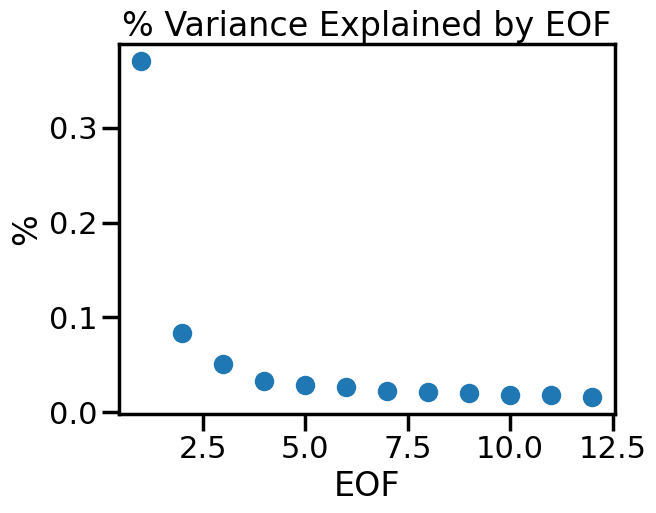

In [142]:
Y, SVD_mat, theta_mean, not_wet = do_EOF_on_xarray(NINO_97_ds_anom.values)
u, s, vh = SVD_mat
perc_var = [lam**2 / np.sum(s**2) for lam in s[0:12]]
plt.scatter(range(1, len(perc_var)+1), perc_var)
plt.title("% Variance Explained by EOF")
plt.xlabel("EOF")
plt.ylabel("%")
plt.savefig("EOFPercVar.png", dpi = 400)

In [143]:
EOF1 = np.copy(u[:, 0])
EOF1[not_wet] = np.nan
EOF1 = np.reshape(EOF1, (r_dim, c_dim))

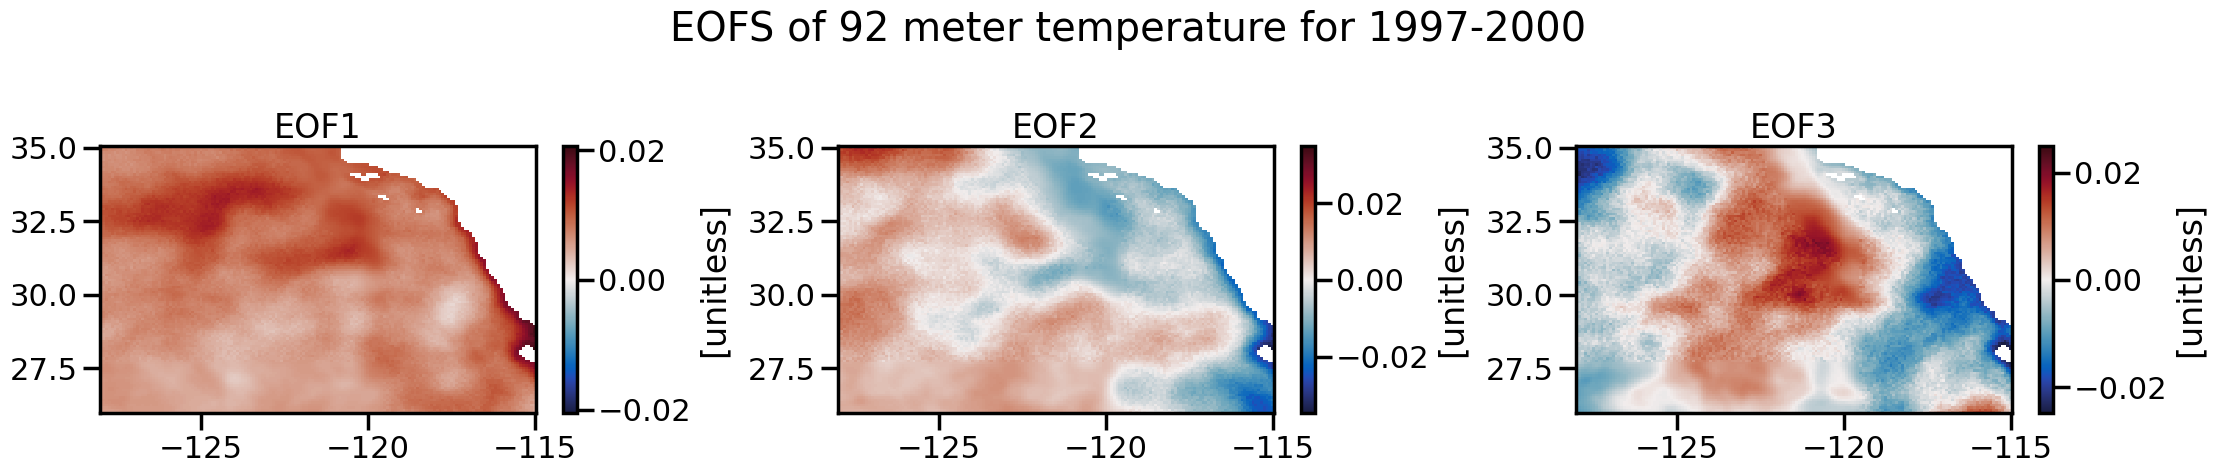

In [145]:
import cmocean
cmap = cmocean.cm.balance

neofs = 3
fig,ax = plt.subplots(ncols = neofs, figsize = (22.5, 5))
LONS, LATS = np.meshgrid(NINO_97_ds_anom.longitude, NINO_97_ds_anom.latitude)
for i in range(0, neofs):
    EOF = np.copy(u[:, i])
    EOF[not_wet] = np.nan
    EOF = np.reshape(EOF, (r_dim, c_dim))
    bounds = np.nanmax(np.abs(EOF))
    cf = ax[i].pcolormesh(LONS, LATS, EOF, cmap = cmap, vmin = -bounds, vmax = bounds)
    cbar = fig.colorbar(cf, label = "[unitless]", ax = ax[i])
    # ax[i].plot(xs_C, ys_C, color = "red", label = "Line of interest"); 
    ax[i].set_title("EOF" + str(i+1))

fig.suptitle("EOFS of 92 meter temperature for 1997-2000")
fig.tight_layout()
fig.savefig("EOFs3.png", dpi = 400)

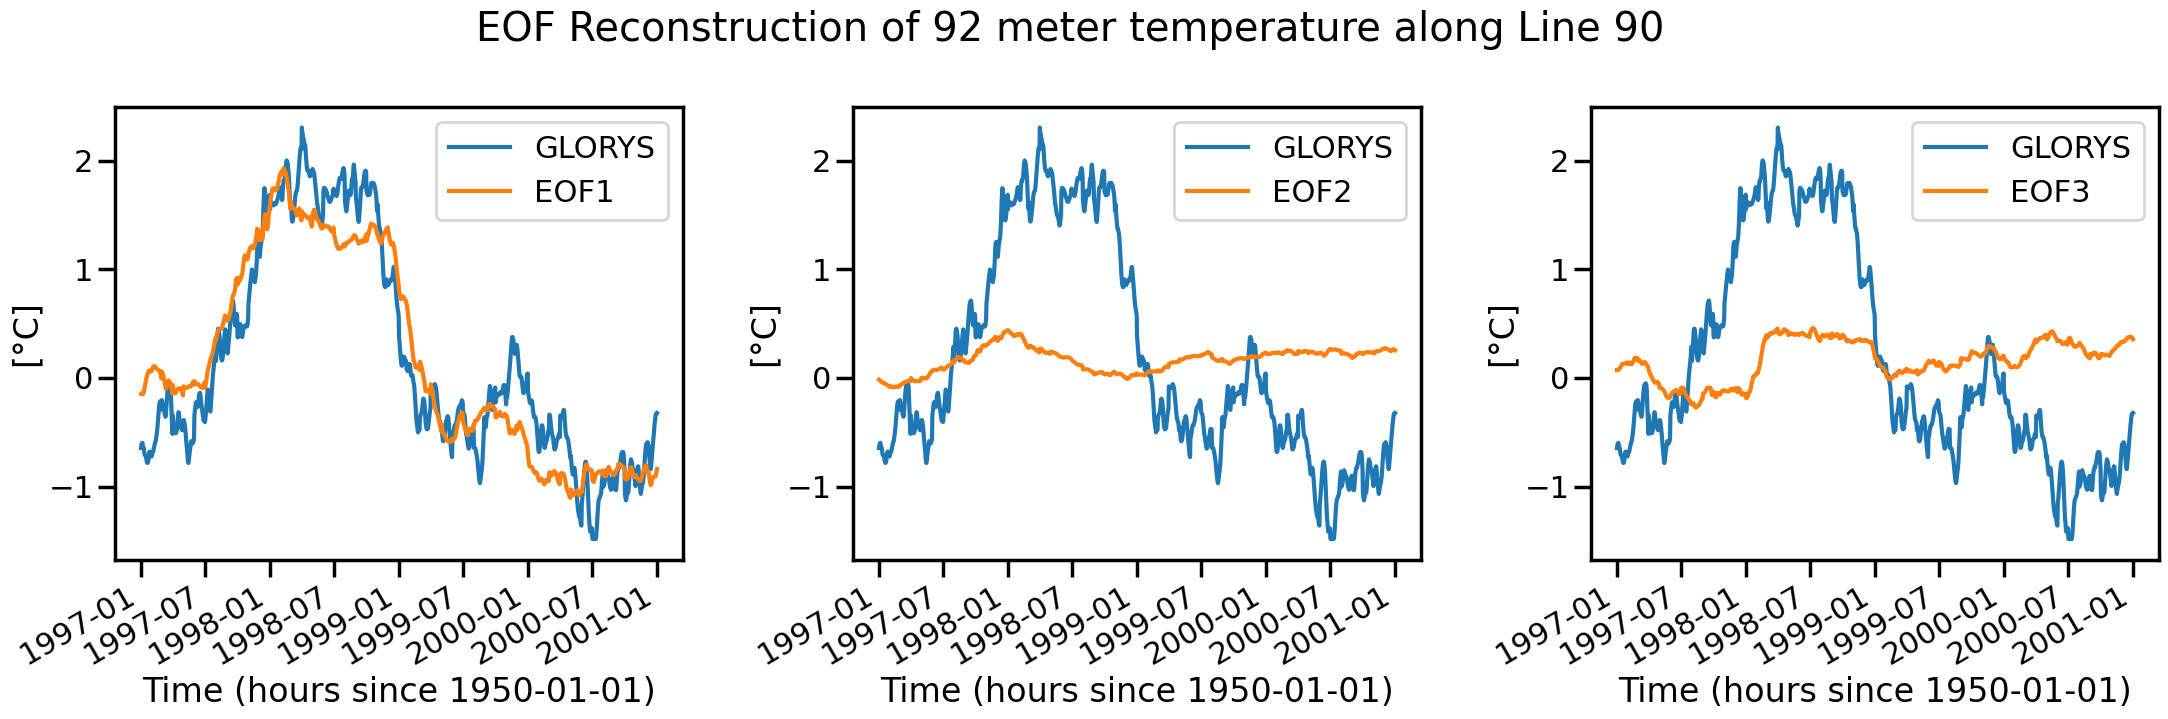

In [121]:
#get time evolution from EOF1 
ds_anom = NINO_97_ds_anom

fig,axes = plt.subplots(ncols = neofs, figsize = (22.5, 7.5))

crop_NINO34 = remove_seasonal(NINO34).sel(time = slice(ds_anom.time.values[0], ds_anom.time.values[-1]))
t_max = crop_NINO34.time[np.argmax(crop_NINO34.values)]

i_ind, j_ind = get_latlon_idx(ds_anom, xs_C, ys_C)
lat_inds = xr.DataArray(i_ind, dims="points")
lon_inds = xr.DataArray(j_ind, dims="points")
    
for (i, ax) in enumerate(axes.flatten()):
    U = u[:, i:i+1];
    beta = U.T @ Y #get expansion coefs for first EOF
    #add back mean
    Y_approx = U @ beta
    Y_approx =  Y_approx.T + theta_mean.flatten()
    Y_approx = Y_approx.reshape((t_dim, r_dim, c_dim))
    #create xarray and subset along line of interest
    Y_approx= ds_anom * 0 + Y_approx
    Y_mean = ds_anom.isel(time = 0).drop("time") * 0 + theta_mean
    #plot along this line 
    line90 = ds_anom.isel(longitude = lon_inds, latitude = lat_inds)
    line90 = line90.mean(dim=['points'], skipna=True) 

    line90_EOF1 = Y_approx.isel(longitude = lon_inds, latitude = lat_inds)
    line90_EOF1 = line90_EOF1.mean(dim=['points'], skipna=True) 
    line90_mean = Y_mean.isel(longitude = lon_inds, latitude = lat_inds)
    line90_mean = line90_mean.mean(dim=['points'], skipna=True) 



    line90.plot(label = "GLORYS", ax = ax)
    line90_EOF1.plot(label = "EOF" + str(i+1) + "", ax = ax)
    # ax.vlines(t_max, 10, 15, color = "k", label = "Peak 97' El Niño")
    # ax.hlines(line90_mean, Y_approx.time.min(), Y_approx.time.max(), color = "k", label = "Mean")
    ax.legend()
    ax.set_ylabel("[°C]")
fig.suptitle("EOF Reconstruction of 92 meter temperature along Line 90")
fig.tight_layout()
fig.savefig("EOFsReconstructions.png", dpi = 400)

/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


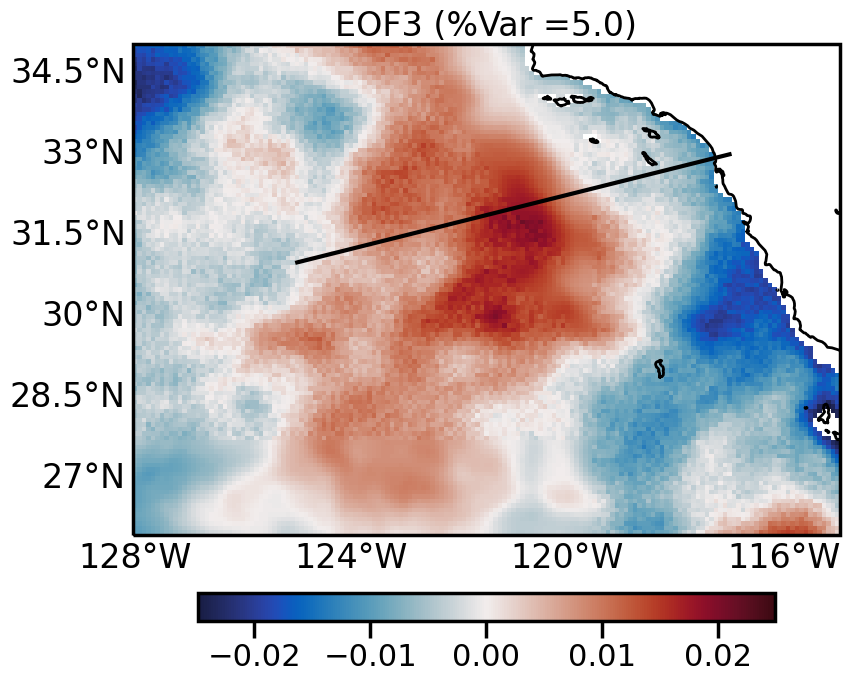

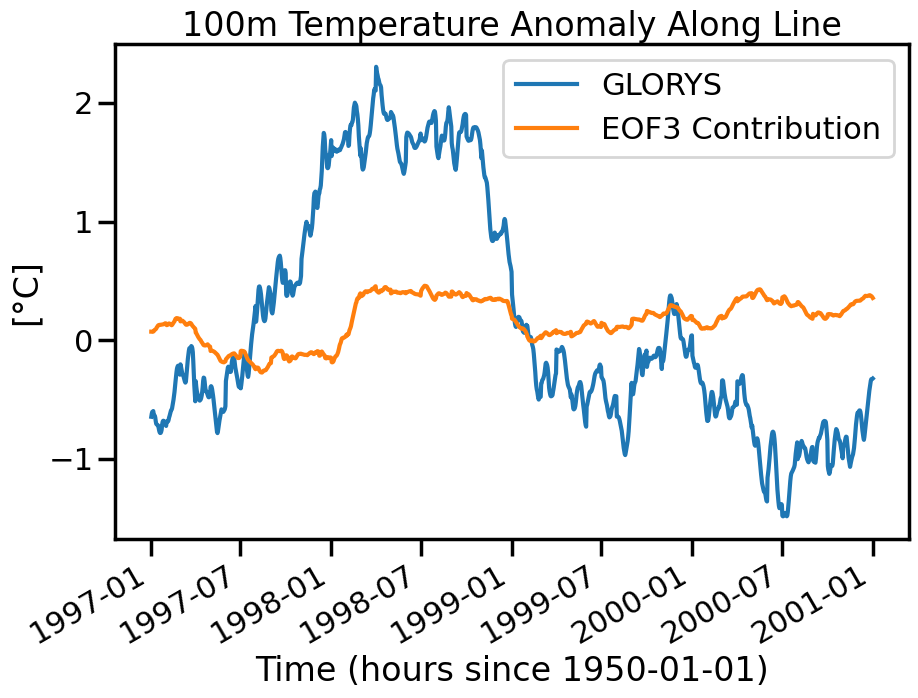

In [123]:
import cmocean
cmap = cmocean.cm.balance

fig,ax = plt.subplots(ncols =1, figsize = (10, 7.5),  subplot_kw = {"projection":ccrs.PlateCarree()})
LONS, LATS = np.meshgrid(NINO_97_ds_anom.longitude, NINO_97_ds_anom.latitude)

EOF = np.copy(u[:, 2])
EOF[not_wet] = np.nan
EOF = np.reshape(EOF, (r_dim, c_dim))
bounds = np.nanmax(np.abs(EOF))
cf = ax.pcolormesh(LONS, LATS, EOF, cmap = cmap, vmin = -bounds, vmax = bounds)
cbar = fig.colorbar(cf, label = "", ax = ax, orientation = "horizontal",  fraction=0.05, 
                             pad=0.1)
ax.plot(xs_C, ys_C, color = "black"); 
ax.coastlines()
ax.set_title("EOF3 (%Var =" + str(100*np.round(perc_var[2], 2)) + ")")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = False
fig.savefig("EOF3_Temperature.png", dpi = 400)


fig,ax = plt.subplots(ncols = 1, figsize = (10, 7.5))
U = u[:, 2:3];
beta = U.T @ Y #get expansion coefs for first EOF
#add back mean
Y_approx = U @ beta
Y_approx =  Y_approx.T + theta_mean.flatten()
Y_approx = Y_approx.reshape((t_dim, r_dim, c_dim))
#create xarray and subset along line of interest
Y_approx= ds_anom * 0 + Y_approx
Y_mean = ds_anom.isel(time = 0).drop("time") * 0 + theta_mean
#plot along this line 
line90 = ds_anom.isel(longitude = lon_inds, latitude = lat_inds)
line90 = line90.mean(dim=['points'], skipna=True) 

line90_EOF1 = Y_approx.isel(longitude = lon_inds, latitude = lat_inds)
line90_EOF1 = line90_EOF1.mean(dim=['points'], skipna=True) 
line90_mean = Y_mean.isel(longitude = lon_inds, latitude = lat_inds)
line90_mean = line90_mean.mean(dim=['points'], skipna=True) 




line90.plot(label = "GLORYS", ax = ax)
line90_EOF1.plot(label = "EOF3 Contribution", ax = ax)
# ax.vlines(t_max, 10, 15, color = "k", label = "Peak 97' El Niño")
# ax.hlines(line90_mean, Y_approx.time.min(), Y_approx.time.max(), color = "k", label = "Mean")
ax.legend()
ax.set_ylabel("[°C]")
ax.set_title("100m Temperature Anomaly Along Line")
# fig.suptitle("EOFS of 92 meter temperature for 1997-2000")
fig.tight_layout()
fig.savefig("EOF3_Contribution.png", dpi = 400)


In [146]:
%%time 
NINO_97_ds_ERA5 = xr.load_dataset("GLORYS_processed/ERA5_monthly.nc")
NINO_97_ds_ERA5_anom = remove_seasonal(NINO_97_ds_ERA5)
NINO_97_ds_ERA5_anom = NINO_97_ds_ERA5_anom.sel(time = slice("1997", "2000"), longitude = slice(None, None))

CPU times: user 42.2 ms, sys: 5.52 ms, total: 47.7 ms
Wall time: 46.9 ms


In [147]:
NINO_97_ds_ERA5_anom.tp.mean(dim = ['longitude', 'latitude']);

In [148]:
t_dim, r_dim, c_dim =NINO_97_ds_ERA5_anom.tp.shape
t_dim, r_dim, c_dim

(48, 41, 53)

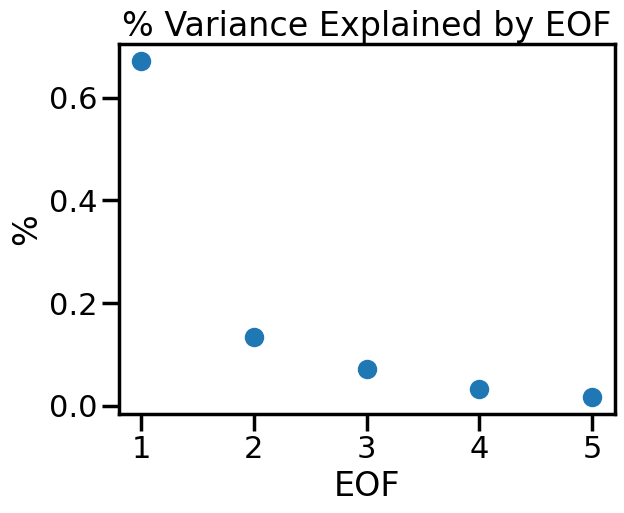

In [149]:
Y, SVD_mat, tpmean, not_wet = do_EOF_on_xarray(NINO_97_ds_ERA5_anom.tp.values)
u, s, vh = SVD_mat
perc_var = [lam**2 / np.sum(s**2) for lam in s[0:5]]
plt.scatter(range(1, len(perc_var)+1), perc_var)
plt.title("% Variance Explained by EOF")
plt.xlabel("EOF")
plt.ylabel("%")
plt.savefig("EOFPercVarPrecip.png", dpi = 400)

/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: T

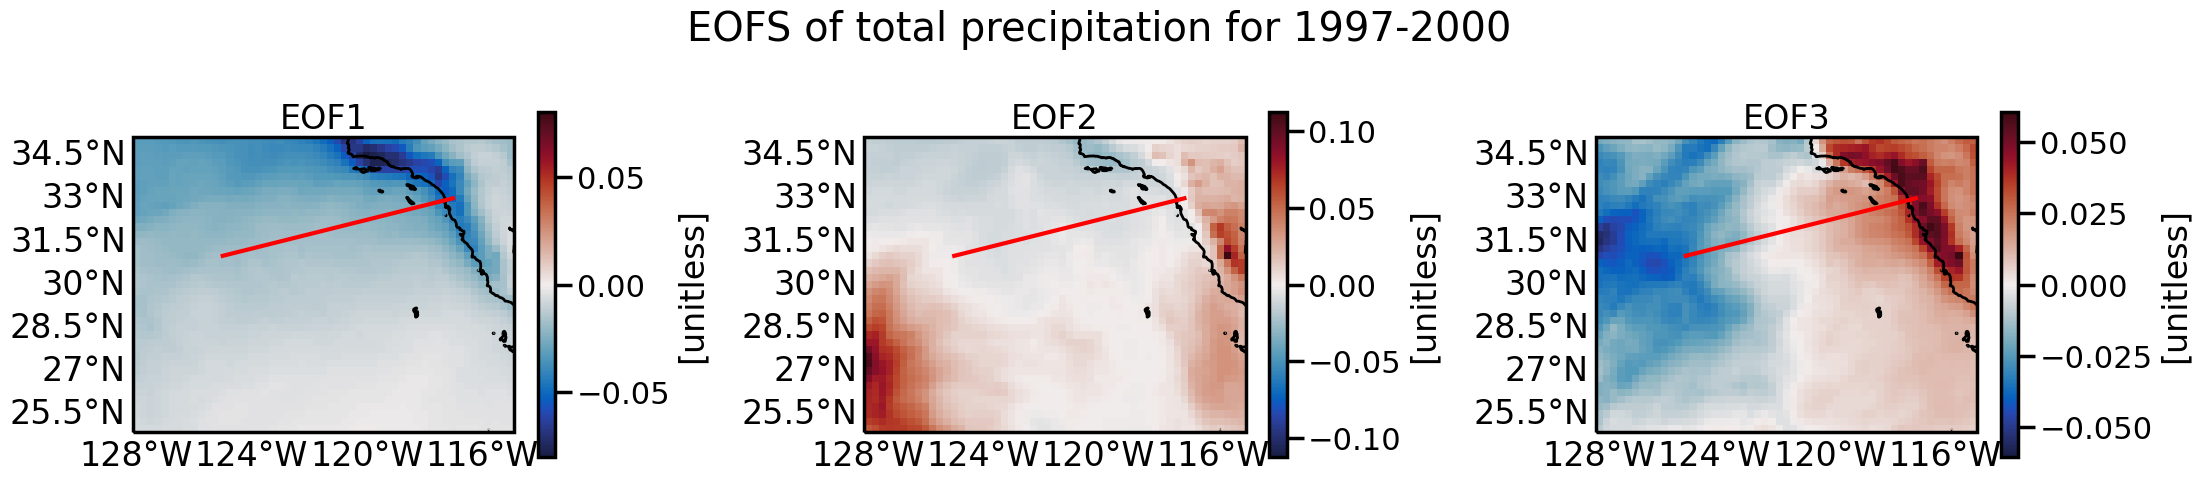

In [159]:
import cmocean
import cartopy.crs as ccrs

cmap = cmocean.cm.balance

neofs = 3
fig,ax = plt.subplots(ncols = neofs, figsize = (22.5, 5), subplot_kw = {'projection':ccrs.PlateCarree()})
LONS, LATS = np.meshgrid(NINO_97_ds_ERA5_anom.longitude, NINO_97_ds_ERA5_anom.latitude)

for i in range(0, neofs):
    gl = ax[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.0, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlines = False
    EOF = np.copy(u[:, i])
    EOF[not_wet] = np.nan
    EOF = np.reshape(EOF, (r_dim, c_dim))
    bounds = np.nanmax(np.abs(EOF))
    cf = ax[i].pcolormesh(LONS, LATS[::-1, :], EOF[::-1, :], cmap = cmap, vmin = -bounds, vmax = bounds)
    cbar = fig.colorbar(cf, label = "[unitless]", ax = ax[i])
    ax[i].plot(xs_C, ys_C, color = "red", label = "Line of interest"); 
    ax[i].set_title("EOF" + str(i+1))
    ax[i].coastlines()

fig.suptitle("EOFS of total precipitation for 1997-2000")
fig.tight_layout()
fig.savefig("EOFs_Precip.png", dpi = 400)

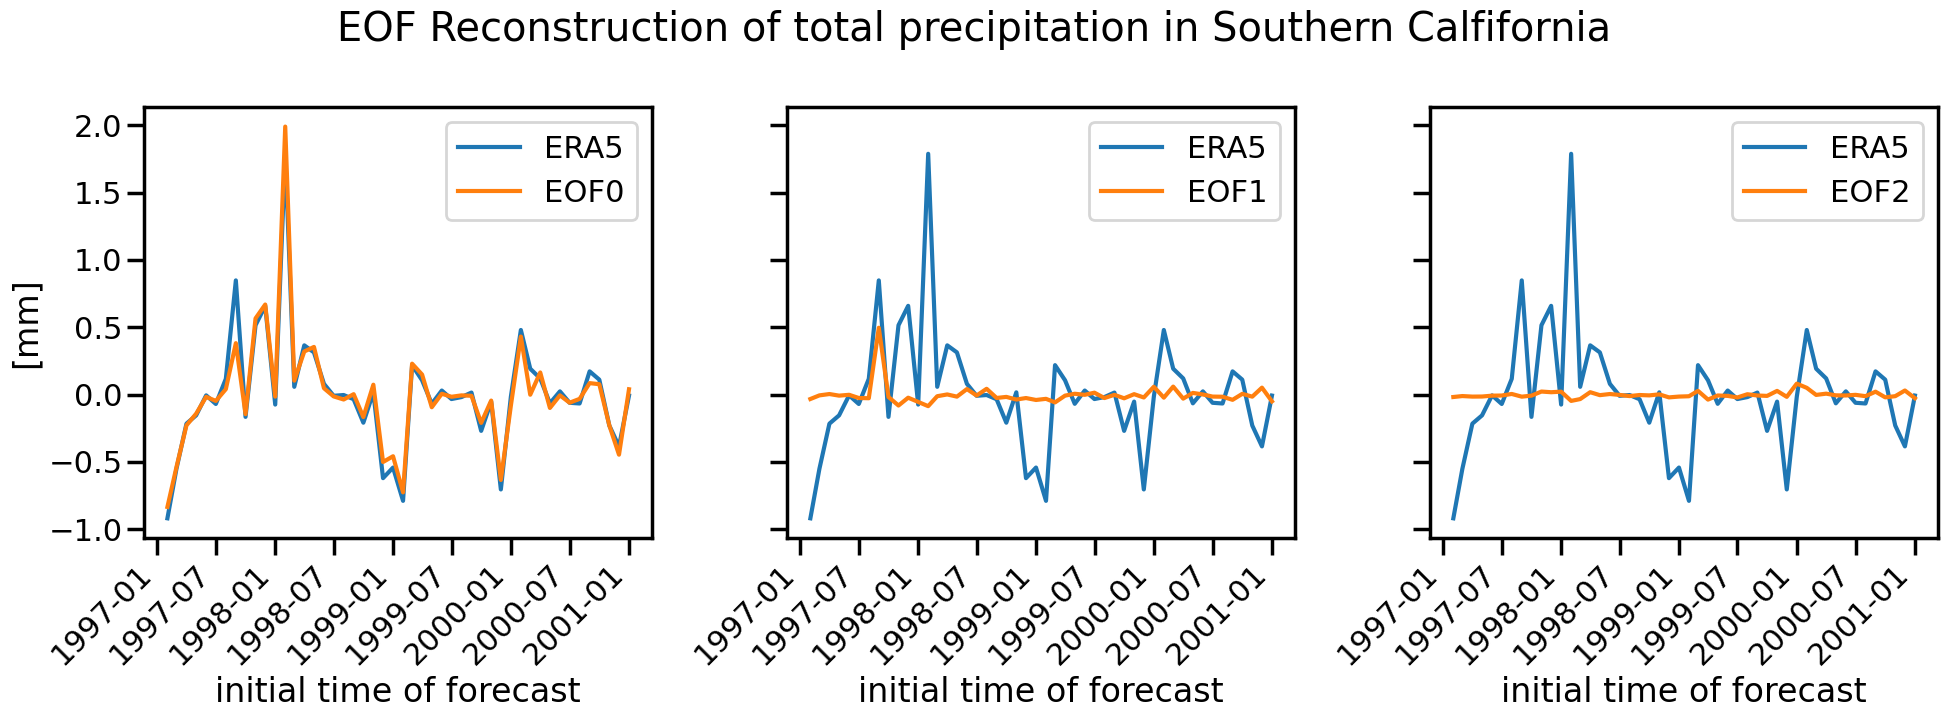

In [163]:
#get time evolution from EOF1 
ds_anom = NINO_97_ds_ERA5_anom


fig,axes = plt.subplots(ncols = neofs, figsize = (20, 7.5), sharey = True)
crop_NINO34 = remove_seasonal(NINO34).sel(time = slice(ds_anom.time.values[0], ds_anom.time.values[-1]))
t_max = crop_NINO34.time[np.argmax(crop_NINO34.values)]
    
for (i, ax) in enumerate(axes):
    U = u[:, i:i+1];
    beta = U.T @ Y #get expansion coefs for first EOF
    # add back mean
    Y_approx = U @ beta
    Y_approx =  Y_approx.T + tpmean.flatten()
    Y_approx = Y_approx.reshape((t_dim, r_dim, c_dim))
    #create xarray and subset along line of interest
    Y_approx= ds_anom.tp * 0 + Y_approx
    socal_tp = 1e3 * ds_anom.tp.mean(dim = ['longitude', 'latitude']).drop(["number", "step", "surface", "valid_time"])

    socal_tp_EOF1 = 1e3 * Y_approx.mean(dim = ['longitude', 'latitude'])
    # ax.vlines(t_max, socal_tp.min(), socal_tp.max(), color = "k", label = "Peak 97' El Niño", linestyle = "--")


    socal_tp.plot(label = "ERA5", ax = ax)
    socal_tp_EOF1.plot(label = "EOF" + str(i) + "", ax = ax)
    ax.set_ylabel("")


    ax.legend()
    ax.xaxis.set_tick_params(rotation=45)
# fig.suptitle("EOF Reconstruction of 92 meter temperature along Line 90")
# fig.tight_layout()
axes[0].set_ylabel("[mm]")

fig.suptitle("EOF Reconstruction of total precipitation in Southern Calfifornia")
fig.tight_layout()
fig.savefig("EOFs3PrecipReconstruction.png", dpi = 400)

/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/vortexfs1/home/anthony.meza/.conda/envs/notebook_env/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


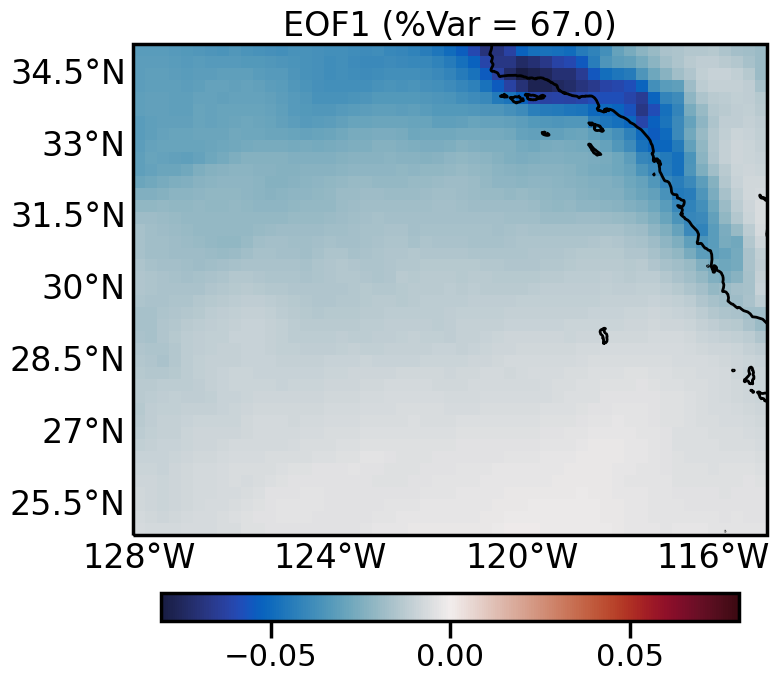

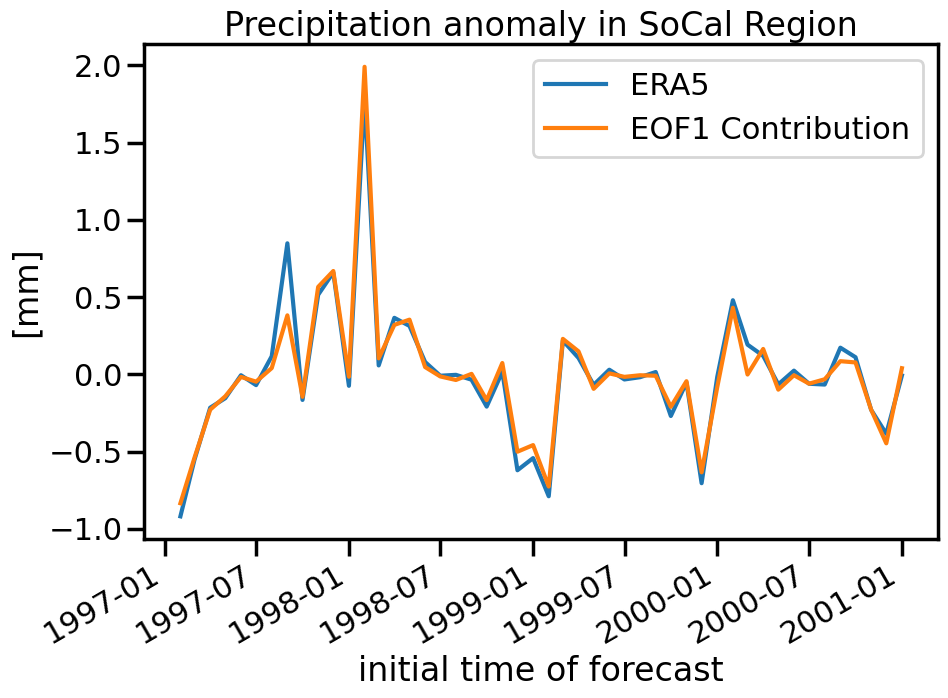

In [138]:
import cmocean
cmap = cmocean.cm.balance
ds_anom = NINO_97_ds_ERA5_anom


fig,ax = plt.subplots(ncols =1, figsize = (10, 7.5),  subplot_kw = {"projection":ccrs.PlateCarree()})
LONS, LATS = np.meshgrid(ds_anom.longitude, ds_anom.latitude)

EOF = np.copy(u[:, 0:1])
EOF[not_wet] = np.nan
EOF = np.reshape(EOF, (r_dim, c_dim))
bounds = np.nanmax(np.abs(EOF))
cf = ax.pcolormesh(LONS, LATS, EOF, cmap = cmap, vmin = -bounds, vmax = bounds)
cbar = fig.colorbar(cf, label = "", ax = ax, orientation = "horizontal",  fraction=0.05, 
                             pad=0.1)
# ax.plot(xs_C, ys_C, color = "black"); 
ax.coastlines()
ax.set_title("EOF1 (%Var = " + str(100*np.round(perc_var[0], 2)) + ")")
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.0, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlines = False
fig.savefig("EOF3_Precip.png", dpi = 400)

fig,ax = plt.subplots(ncols = 1, figsize = (10, 7.5))
U = u[:, 0:1];
beta = U.T @ Y #get expansion coefs for first EOF
#add back mean
Y_approx = U @ beta
Y_approx =  Y_approx.T + tpmean.flatten()
Y_approx = Y_approx.reshape((t_dim, r_dim, c_dim))
#create xarray and subset along line of interest
Y_approx= ds_anom.tp * 0 + Y_approx
socal_tp = 1e3*ds_anom.tp.mean(dim = ['longitude', 'latitude']).drop(["number", "step", "surface", "valid_time"])
socal_tp_EOF1 = 1e3*Y_approx.mean(dim = ['longitude', 'latitude'])
# ax.vlines(t_max, socal_tp.min(), socal_tp.max(), color = "k", label = "Peak 97' El Niño", linestyle = "--")
socal_tp.plot(label = "ERA5", ax = ax)
socal_tp_EOF1.plot(label = "EOF1 Contribution", ax = ax)
# ax.vlines(t_max, 10, 15, color = "k", label = "Peak 97' El Niño")
# ax.hlines(line90_mean, Y_approx.time.min(), Y_approx.time.max(), color = "k", label = "Mean")
ax.legend()
ax.set_ylabel("[mm]")
ax.set_title("Precipitation anomaly in SoCal Region")
# fig.suptitle("EOFS of 92 meter temperature for 1997-2000")
fig.tight_layout()
fig.savefig("EOF3_ContributionPrecip.png", dpi = 400)



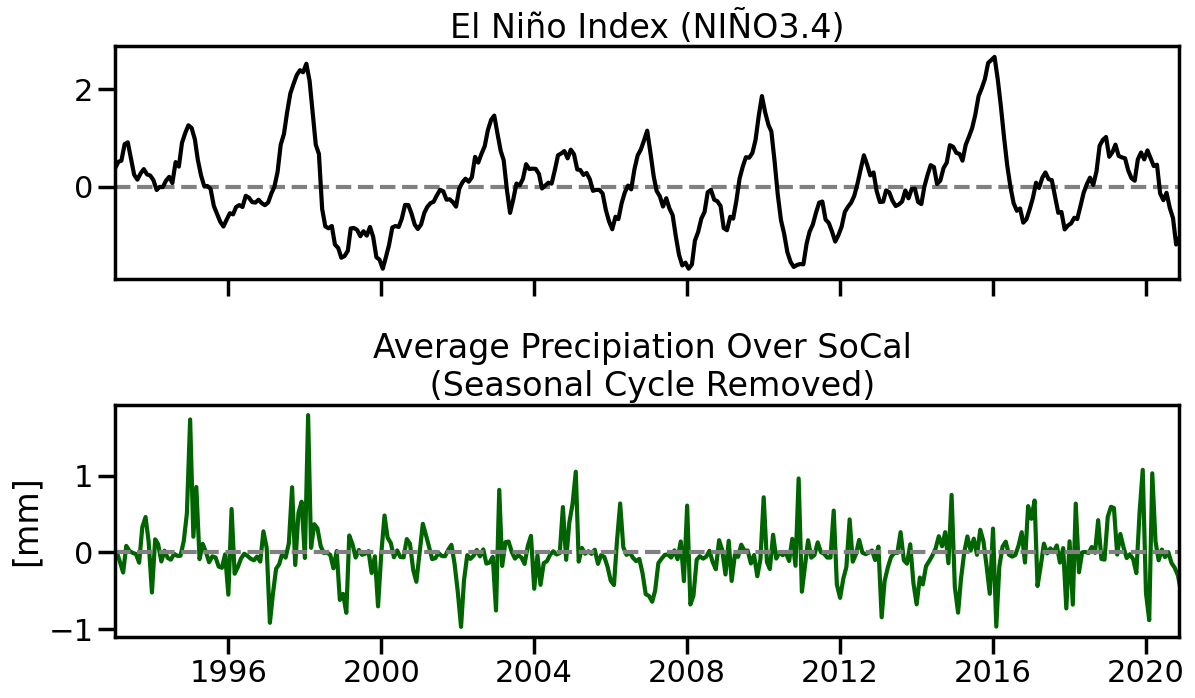

In [139]:
ds_anom_ds_ERA5 = xr.load_dataset("GLORYS_processed/ERA5_monthly.nc")
ds_anom = remove_seasonal(NINO_97_ds_ERA5.tp)
crop_NINO34 = remove_seasonal(NINO34).sel(time = slice(ds_anom.time.values[0], ds_anom.time.values[-1]))
fig,axes = plt.subplots(2, 1, figsize = (12.5, 7.5), sharex = True)

normal_tp = (ds_anom.mean(dim = ["latitude", "longitude"]).sel(time = slice("1993", None)))
normal_tp = normal_tp
normal_tp[0] = 0
normal_NINO34 = (crop_NINO34)
axes[0].hlines(0, crop_NINO34.time.min(), crop_NINO34.time.max(), color = "grey", linestyle = "--")
axes[0].plot(crop_NINO34.time, normal_NINO34, label = "NINO3.4", color = "k")
axes[1].plot(normal_tp.time, 1e3 * normal_tp,label = "Total Precipitation", color = "darkgreen")
axes[1].set_ylabel("[mm]")
axes[1].hlines(0, crop_NINO34.time.min(), crop_NINO34.time.max(), color = "grey", linestyle = "--")
axes[0].set_title("El Niño Index (NIÑO3.4)")
axes[1].set_title("Average Precipiation Over SoCal \n (Seasonal Cycle Removed)")


# axes.legend()

# axes.set_ylim(-5.2, 5.2)
axes[0].set_xlim(crop_NINO34.time.min(), crop_NINO34.time.max())
fig.tight_layout()
fig.savefig("NINOPRECIP.png", dpi = 400)


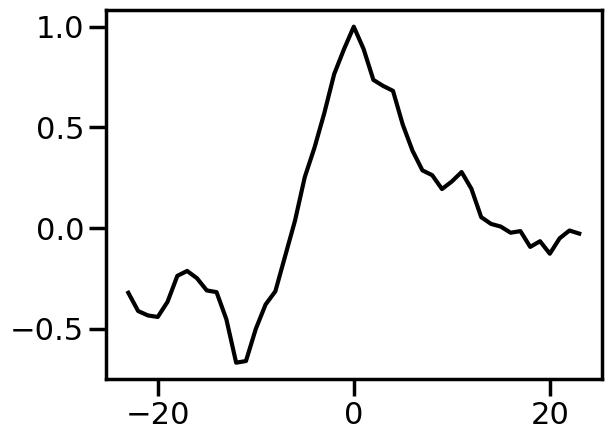

In [275]:
from scipy import signal

corr = signal.correlate(normalize(normal_tp), normalize(crop_NINO34))
corr /= np.max(corr)
lags = signal.correlation_lags(len(normal_tp), len(crop_NINO34))
inyear = np.argwhere((-2*12 < lags)&(lags < 2*12))
plt.plot(lags[inyear], corr[inyear], c = "k")
# axes[0, i].legend()
#WHY DOES THIS GIVE DIFFERENT ANSER FROM PEARSON R

In [271]:
def covariance(x,y):
    return np.sum( (x - np.mean(x)  ) * (y - np.mean(y) ) )
np.sum((crop_NINO34 - np.mean(crop_NINO34)).values * (normal_tp - np.mean(normal_tp) ).values) / (len(normal_tp) * np.std(normal_tp) * np.std(normal_NINO34))

<xarray.DataArray ()>
array(0.20921955)

In [242]:
from scipy.stats import pearsonr
pearsonr(normal_tp, normal_NINO34)

PearsonRResult(statistic=0.209219565582599, pvalue=0.00011440605889391493)

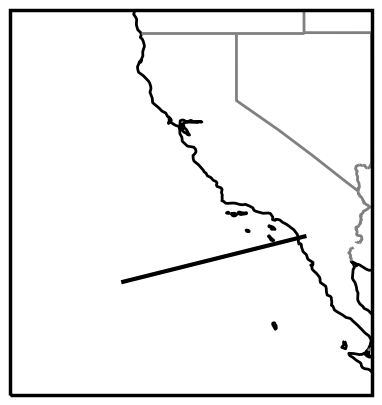

In [335]:

import cmocean
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
cmaps = cmocean.cm.topo

# e(-128, -115), latitude = slice(26, 35)
fig, ax = plt.subplots(figsize = (5, 5), subplot_kw = {"projection":ccrs.PlateCarree()} )
ax.set_extent([-130, -114, 26, 43])

# Put a background image on for nice sea rendering.
# ax.stock_img()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '110m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
# ax.add_feature(land_50m)
ax.plot(xs_C, ys_C, color = "black"); 


ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')
# ax.add_feature(cfeature.STATES, linewidth=0.3, edgecolor='k')
# plt.clabel(CS, fontsize=9, inline=1)

# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=2, color='gray', alpha=0.0, linestyle='--')
# gl.xlabels_top = False
# gl.ylabels_right = False
# gl.xlines = False
# gl.xformatter = LONGITUDE_FORMATTER
# gl.yformatter = LATITUDE_FORMATTER
# plt.show()
# fig.tight_layout()
plt.savefig("CalifornianwLine.pdf")